In [1]:
# -------------------------------------------------------------------------------
# Name: main.py
# Purpose: Pull data from twitter, perform sentiment analysis and pull stock data
#
# Author(s):    David Little
#
# Created:      04/26/2021
# Updated:
# Update Comment(s):
#
# TO DO:
#
# -------------------------------------------------------------------------------


import requests
import pandas as pd
import time
import regex as re
from datetime import datetime, timedelta

In [3]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweet_count': tweet['public_metrics']['retweet_count'],
        'like_count': tweet['public_metrics']['like_count'],
        'reply_count': tweet['public_metrics']['reply_count']
#        'quote_count': tweet['public_metrics']['quote_count']
    }
    return data

In [4]:
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

In [5]:
#------------------------------------- Twitter Pull  --------------------------------------------------------

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'  # 'https://api.twitter.com/2/tweets/search/all'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(tesla OR tsla OR elon musk and -spacex) (lang:en)', # -is:retweet
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
        }

In [6]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)

In [7]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
now

'2021-09-02T10:35:58Z'

In [8]:
df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 6 days ago, break the loop
        break
    pre60 = time_travel(now, 5)  # get x minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    time.sleep(2)
    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    for tweet in response.json()['data']:
        row = get_data(tweet)  # we defined this function earlier
        if row['like_count']>=0 and row['retweet_count']>=0 and row['reply_count']>=0:   #row['like_count'] >=3:
            df = df.append(row, ignore_index=True)
df

,created_at,id,like_count,reply_count,retweet_count,text
0,2021-09-02T10:35:53.000Z,1433378135999930368,0.0,0.0,430.0,RT @K9NFT: 👾 NFT GIVEAWAY👾\n🐾 $DOGE #6 NFT🐾\n\...
1,2021-09-02T10:35:52.000Z,1433378133646868480,0.0,0.0,249.0,RT @Chatex_bot: 6 GORGEOUS NFTS ARE STILL WAIT...
2,2021-09-02T10:35:49.000Z,1433378122494218247,0.0,0.0,430.0,RT @K9NFT: 👾 NFT GIVEAWAY👾\n🐾 $DOGE #6 NFT🐾\n\...
3,2021-09-02T10:35:46.000Z,1433378109286453253,0.0,0.0,1140.0,RT @DaddyDanToMars: @elonmusk Thank you for ev...
4,2021-09-02T10:35:44.000Z,1433378098754428931,0.0,0.0,0.0,Discuss the promotion strategies and the compe...
...,...,...,...,...,...,...
168965,2021-08-27T10:36:17.000Z,1431203911457820673,0.0,0.0,0.0,"@binance The best community, the best dog, Dog..."
168966,2021-08-27T10:36:15.000Z,1431203901513080841,0.0,0.0,252.0,RT @Investingcom: *TESLA FILES TO BECOME AN EL...
168967,2021-08-27T10:36:12.000Z,1431203888418496519,0.0,1.0,0.0,@yigebaizhongren @DisruptivDecade @Adin_Palenc...
168968,2021-08-27T10:36:00.000Z,1431203841467469828,0.0,0.0,1.0,"RT @JasonRaznick: Stephen Curry, Lebron James ..."


In [9]:
#---------------------------------------------- Sentiment Model ------------------------------------------------------

import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# we will append probability and sentiment preds later
probs = []
sentiments = []
clean_tweets = []
timestamp = []
binary = []

for time in df['created_at']:
    timestamp.append(((datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ')
                      - timedelta(hours = 4)) #timezone
                      + timedelta(hours = 0) #delay
                     ).strftime('%Y-%m-%d')) # %H:00:00'))

for tweet in df['text']:
# we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    if sentence.labels[0].value == 'NEGATIVE':
        probs.append(-1 * sentence.labels[0].score)  # numerical score 0-1
        binary.append(0)
    else:
        probs.append(sentence.labels[0].score)  # numerical score 0-1
        binary.append(1)
    clean_tweets.append(tweet)
    # print(tweet)
    # print(' ')

# add probability and sentiment predictions to tweets dataframe
df['text_clean'] = clean_tweets
df['probability'] = probs
df['sentiment'] = sentiments
df['binary'] = binary
df['Date'] = timestamp
#df['Date'] = pd.to_datetime(df['Date'])
df

2021-09-02 12:50:05,737 loading file C:\Users\djlittle\.flair\models\sentiment-en-mix-distillbert_4.pt


,created_at,id,like_count,reply_count,retweet_count,text,text_clean,probability,sentiment,binary,Date
0,2021-09-02T10:35:53.000Z,1433378135999930368,0.0,0.0,430.0,RT @K9NFT: 👾 NFT GIVEAWAY👾\n🐾 $DOGE #6 NFT🐾\n\...,RT : 👾 NFT GIVEAWAY👾 🐾 $DOGE #6 NFT🐾 ♥️ Follow...,-0.617338,NEGATIVE,0,2021-09-02
1,2021-09-02T10:35:52.000Z,1433378133646868480,0.0,0.0,249.0,RT @Chatex_bot: 6 GORGEOUS NFTS ARE STILL WAIT...,RT : 6 GORGEOUS NFTS ARE STILL WAITING FOR THE...,0.999566,POSITIVE,1,2021-09-02
2,2021-09-02T10:35:49.000Z,1433378122494218247,0.0,0.0,430.0,RT @K9NFT: 👾 NFT GIVEAWAY👾\n🐾 $DOGE #6 NFT🐾\n\...,RT : 👾 NFT GIVEAWAY👾 🐾 $DOGE #6 NFT🐾 ♥️ Follow...,-0.617338,NEGATIVE,0,2021-09-02
3,2021-09-02T10:35:46.000Z,1433378109286453253,0.0,0.0,1140.0,RT @DaddyDanToMars: @elonmusk Thank you for ev...,RT : Thank you for everything you do ! The #S...,0.708918,POSITIVE,1,2021-09-02
4,2021-09-02T10:35:44.000Z,1433378098754428931,0.0,0.0,0.0,Discuss the promotion strategies and the compe...,Discuss the promotion strategies and the compe...,0.994739,POSITIVE,1,2021-09-02
...,...,...,...,...,...,...,...,...,...,...,...
168965,2021-08-27T10:36:17.000Z,1431203911457820673,0.0,0.0,0.0,"@binance The best community, the best dog, Dog...","The best community, the best dog, Doge big br...",0.999417,POSITIVE,1,2021-08-27
168966,2021-08-27T10:36:15.000Z,1431203901513080841,0.0,0.0,252.0,RT @Investingcom: *TESLA FILES TO BECOME AN EL...,RT : *TESLA FILES TO BECOME AN ELECTRICITY PRO...,-0.918294,NEGATIVE,0,2021-08-27
168967,2021-08-27T10:36:12.000Z,1431203888418496519,0.0,1.0,0.0,@yigebaizhongren @DisruptivDecade @Adin_Palenc...,Can't stop everything but 2000 t-shirt = ...,-0.996284,NEGATIVE,0,2021-08-27
168968,2021-08-27T10:36:00.000Z,1431203841467469828,0.0,0.0,1.0,"RT @JasonRaznick: Stephen Curry, Lebron James ...","RT : Stephen Curry, Lebron James And Other NBA...",0.780260,POSITIVE,1,2021-08-27


In [10]:
# df.to_csv("TwitterData.csv")

In [11]:
#________________________________ Stock Data __________________________________________________________________

import yfinance as yf

#tsla = yf.Ticker("TSLA")
tsla = yf.download( "TSLA",
    start=datetime.strptime(df['created_at'].min(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    end=(datetime.strptime(df['created_at'].max(),'%Y-%m-%dT%H:%M:%S.%fZ')+timedelta(days = 2)).strftime('%Y-%m-%d'),
    interval='1d' #'60m'
        )#.reset_index()
tsla_stock = tsla.pct_change().reset_index()

[*********************100%***********************]  1 of 1 completed


In [12]:
converted = []
for time in tsla_stock['Date']:
    converted.append(time.strftime('%Y-%m-%d')) # %H:00:00'))
tsla_stock['Date'] = converted
#tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])
tsla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-27,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-30,0.013787,0.022378,0.015140,0.026674,0.026674,0.351843
2,2021-08-31,0.025576,0.012845,0.019236,0.006581,0.006581,0.121005
3,2021-09-01,0.001473,0.002161,0.006649,-0.002215,-0.002215,-0.366864
4,2021-09-02,0.000572,-0.001375,-0.000998,-0.002316,-0.002316,-0.043292


In [13]:
means = df.groupby(['Date'],  as_index=False).mean()
means

,Date,like_count,reply_count,retweet_count,probability,binary
0,2021-08-27,4.023702,0.453684,313.788516,0.089486,0.549219
1,2021-08-28,3.573876,0.432413,344.578828,0.035431,0.517818
2,2021-08-29,3.773057,0.392861,340.797000,-0.016087,0.488558
3,2021-08-30,4.997089,0.288716,999.471551,0.123672,0.561069
4,2021-08-31,3.282915,0.309422,3152.348886,-0.203666,0.395334
5,2021-09-01,2.989997,0.322617,858.442721,-0.268962,0.356942
6,2021-09-02,1.332367,0.193292,2320.720464,-0.396338,0.297945


In [14]:
means['Date']

0    2021-08-27
1    2021-08-28
2    2021-08-29
3    2021-08-30
4    2021-08-31
5    2021-09-01
6    2021-09-02
Name: Date, dtype: object

In [15]:
tsla_stock['Date']

0    2021-08-27
1    2021-08-30
2    2021-08-31
3    2021-09-01
4    2021-09-02
Name: Date, dtype: object

In [16]:
combined = means.merge(tsla_stock, how='inner')
combined

,Date,like_count,reply_count,retweet_count,probability,binary,Open,High,Low,Close,Adj Close,Volume
0,2021-08-27,4.023702,0.453684,313.788516,0.089486,0.549219,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-30,4.997089,0.288716,999.471551,0.123672,0.561069,0.013787,0.022378,0.015140,0.026674,0.026674,0.351843
2,2021-08-31,3.282915,0.309422,3152.348886,-0.203666,0.395334,0.025576,0.012845,0.019236,0.006581,0.006581,0.121005
3,2021-09-01,2.989997,0.322617,858.442721,-0.268962,0.356942,0.001473,0.002161,0.006649,-0.002215,-0.002215,-0.366864
4,2021-09-02,1.332367,0.193292,2320.720464,-0.396338,0.297945,0.000572,-0.001375,-0.000998,-0.002316,-0.002316,-0.043292


In [17]:
#combined['like_count'].corr(combined['Close'])
combined['binary'].corr(combined['Close'])

0.9774680763394317

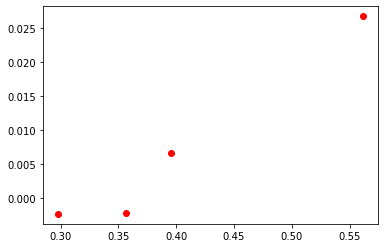

In [18]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['binary'],combined['Close'], 'ro')

In [19]:
#import tweepy

#auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
#auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

#api = tweepy.API(auth)

#public_tweets = api.home_timeline()
#for tweet in public_tweets:
#    print(tweet.text)